In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open("../config.json") as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)["CFBD_API_KEY"]
    )

## 1. Load the Data

In [2]:
YEARS = range(2023, 2024)
DATA_DIR = "../data"

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, "games")
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f"{year}.parquet")
    if os.path.exists(file_path):
        print(f"Reading {file_path} from cached data")
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f"Fetching {year} games data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2023.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,401525434,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0
1,401540199,2023,1,regular,True,True,3689.0,2382,Mercer,Southern,fcs,17.0,NaN,2453,North Alabama,UAC,fcs,7.0,NaN
2,401520145,2023,1,regular,True,False,3662.0,55,Jacksonville State,Conference USA,fbs,17.0,1500.0,2638,UTEP,Conference USA,fbs,14.0,1369.0
3,401525450,2023,1,regular,True,False,3601.0,166,New Mexico State,Conference USA,fbs,30.0,1322.0,113,Massachusetts,FBS Independents,fbs,41.0,1074.0
4,401540628,2023,1,regular,True,False,4419.0,399,UAlbany,CAA,fcs,34.0,NaN,2230,Fordham,Patriot,fcs,13.0,NaN


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, "plays")
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching all weeks' plays data for {year} from CFBD API")
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f"Fetching {year} plays data for week {week} from CFBD API")
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp["clock_minutes"] = df_tmp["clock"].apply(lambda x: x["minutes"])
            df_tmp["clock_seconds"] = df_tmp["clock"].apply(lambda x: x["seconds"])
            df_tmp.drop(columns=["clock"], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f"Saved plays data for {year} to {season_file_path}")
        del df_season_plays, season_dfs, df_tmp

    all_dfs.append(df_season_plays)
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2023.parquet from cached data


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,401540244104995401,40154024433,401540244,22,6,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,67,67,3,28,5,False,Rush,Carlos Matheney run for 5 yds to the LAM 39,0.003424,0,45
1,401540244104994901,40154024433,401540244,22,5,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,66,66,2,27,-1,False,Rush,Carlos Matheney run for a loss of 1 yard to th...,-0.145843,0,50
2,401540244104977803,40154024433,401540244,22,4,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,64,64,1,25,-2,False,Rush,Carlos Matheney run for a loss of 2 yards to t...,-0.464241,2,21
3,401540244104977802,40154024433,401540244,22,3,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,49,49,1,10,-15,False,Rush,"Idaho Penalty, face mask (15 yards) (Carlos Ma...",-3.323128,2,21
4,401540244104977801,40154024433,401540244,22,2,Idaho,Big Sky,42,Lamar,Lamar,Idaho,Southland,17,4,3.0,3.0,65,65,3,10,16,False,Rush,Jack Layne run for 16 yds to the LAM 49 for a ...,3.095490,2,21


In [11]:
df.drive_id.unique()

array(['40152543416', '40152543415', '40152543414', ..., '40161730910',
       '40161730919', '4016173094'], dtype=object)

## 2. Join and Filter the Data

In [7]:
# Merge games and plays data
cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_division','home_points', 'home_pregame_elo', 
        'away_division', 'away_points', 'away_pregame_elo']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

df = (
    df_games.merge(df_plays, left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30
1,401525434,40152543416,401525434104989901,16,7,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,38,62,1,10,2,False,Pass Reception,Steve Angeli pass complete to Rico Flores for ...,-0.665638,1,0
2,401525434,40152543416,401525434104985401,16,6,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,36,64,4,1,2,False,Rush,Audric Estime run for 2 yds to the ND 38 for a...,1.772266,1,45
3,401525434,40152543416,401525434104979501,16,5,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,36,64,3,1,0,False,Rush,Audric Estime run for no gain to the ND 36,-0.762577,2,4
4,401525434,40152543416,401525434104977301,16,3,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,2.0,32,68,2,5,4,False,Rush,Audric Estime run for 4 yds to the ND 36,-0.128046,2,26


In [8]:
# Filter out overtime plays
df = df.query('period <= 4')

# Game must be completed
df = df.query('completed == True')

## 3. Feature Engineering

In [9]:
df = df.assign(
    pct_game_played = (((df['period'] - 1) * 15 * 60) + ((15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))) / (4 * 15 * 60),
    score_diff = df['offense_score'] - df['defense_score'],
    home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
    pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
    pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
    pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
    offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
    score_diff_final = np.where(df['offense'] == df['home'], df['home_points'] - df['away_points'], df['away_points'] - df['home_points'])
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,pct_game_played,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,score_diff_final
0,401525434,40152543416,401525434104996901,16,8,2023,1,regular,True,True,3504.0,87,0,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,40,60,2,8,-2,False,Fumble Recovery (Own),Chris Tyree run for a loss of 2 yards to the N...,-1.116190,0,30,0.991667,39,262.0,1733.0,1471.0,fbs,fbs,39.0
1,401525434,40152543416,401525434104989901,16,7,2023,1,regular,True,True,3504.0,87,0,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,38,62,1,10,2,False,Pass Reception,Steve Angeli pass complete to Rico Flores for ...,-0.665638,1,0,0.983333,39,262.0,1733.0,1471.0,fbs,fbs,39.0
2,401525434,40152543416,401525434104985401,16,6,2023,1,regular,True,True,3504.0,87,0,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,36,64,4,1,2,False,Rush,Audric Estime run for 2 yds to the ND 38 for a...,1.772266,1,45,0.970833,39,262.0,1733.0,1471.0,fbs,fbs,39.0
3,401525434,40152543416,401525434104979501,16,5,2023,1,regular,True,True,3504.0,87,0,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,1.0,36,64,3,1,0,False,Rush,Audric Estime run for no gain to the ND 36,-0.762577,2,4,0.965556,39,262.0,1733.0,1471.0,fbs,fbs,39.0
4,401525434,40152543416,401525434104977301,16,3,2023,1,regular,True,True,3504.0,87,0,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0,Notre Dame,FBS Independents,42,Navy,Notre Dame,Navy,American Athletic,3,4,2.0,2.0,32,68,2,5,4,False,Rush,Audric Estime run for 4 yds to the ND 36,-0.128046,2,26,0.959444,39,262.0,1733.0,1471.0,fbs,fbs,39.0


In [ ]:
df.columns

Index(['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type',
       'venue_id', 'offense', 'offense_conference', 'offense_division',
       'defense', 'defense_conference', 'defense_division', 'score_diff',
       'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo',
       'pct_game_played', 'offense_timeouts', 'defense_timeouts', 'home_team',
       'score_diff_final', 'pct_game_played_bin'],
      dtype='object')

: 

## 4. Final Data

In [ ]:
cols = ['game_id', 'drive_id', 'play_id', 'season', 'week', 'season_type', 'venue_id', 
        'offense', 'offense_conference', 'offense_division', 
        'defense', 'defense_conference', 'defense_division', 
        'score_diff', 'pregame_elo_diff', 'pregame_offense_elo', 'pregame_defense_elo', 'pct_game_played',
        'offense_timeouts', 'defense_timeouts', 'home_team',
        'score_diff_final']

#TODO: remove filtering for FBS only?
df = df[cols].query('offense_division == "fbs" & defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,home_team,score_diff_final
0,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.758333,2.0,1.0,0,39.0
1,401525434,40152543416,401525434104989901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.766667,2.0,1.0,0,39.0
2,401525434,40152543416,401525434104985401,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.779167,2.0,1.0,0,39.0
3,401525434,40152543416,401525434104979501,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.784444,2.0,1.0,0,39.0
4,401525434,40152543416,401525434104977301,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.790556,2.0,2.0,0,39.0


: 

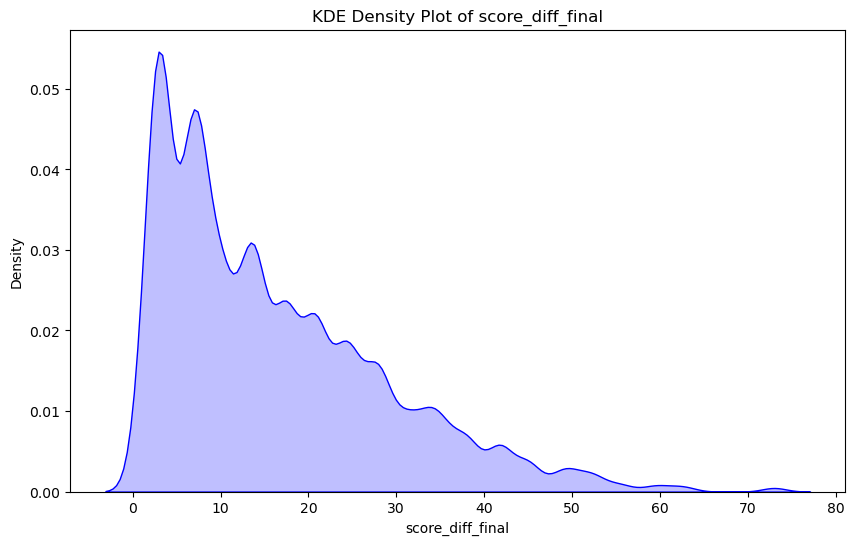

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('score_diff_final >= 0').score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

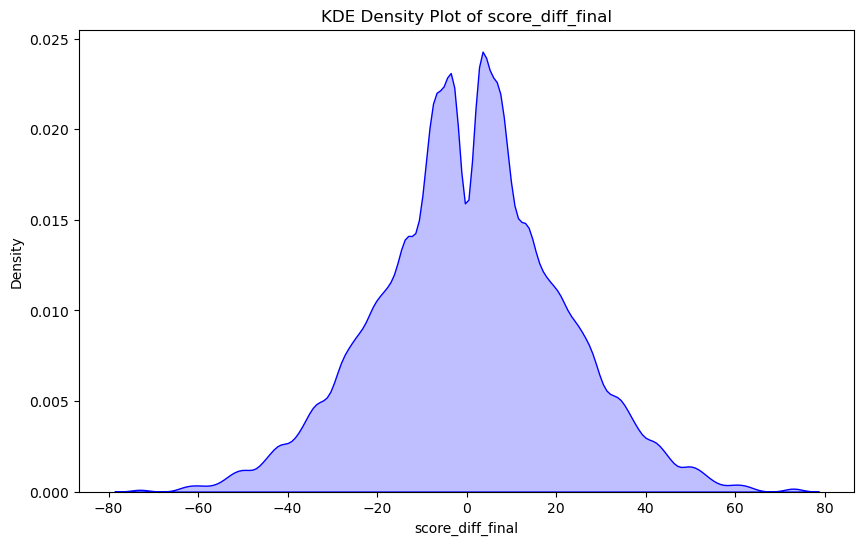

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.score_diff_final, fill=True, color='blue')
plt.title('KDE Density Plot of score_diff_final')
plt.xlabel('score_diff_final')
plt.ylabel('Density')
plt.show()

In [ ]:
df.head()

,game_id,drive_id,play_id,season,week,season_type,venue_id,offense,offense_conference,offense_division,defense,defense_conference,defense_division,score_diff,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,pct_game_played,offense_timeouts,defense_timeouts,home_team,score_diff_final
0,401525434,40152543416,401525434104996901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.758333,2.0,1.0,0,39.0
1,401525434,40152543416,401525434104989901,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.766667,2.0,1.0,0,39.0
2,401525434,40152543416,401525434104985401,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.779167,2.0,1.0,0,39.0
3,401525434,40152543416,401525434104979501,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.784444,2.0,1.0,0,39.0
4,401525434,40152543416,401525434104977301,2023,1,regular,3504.0,Notre Dame,FBS Independents,fbs,Navy,American Athletic,fbs,39,262.0,1733.0,1471.0,0.790556,2.0,2.0,0,39.0


: 

In [ ]:
df['pct_game_played_bin'] = (df['pct_game_played'] * 100).astype(int)

: 

In [ ]:
df.pct_game_played_bin.nunique()

101

: 

In [ ]:
import pymc as pm
import arviz as az

n_cores = os.cpu_count()

n_time_buckets = 101  # 0% to 100%
df_mini = df.sample(5_000, random_state=42)
n_obs = len(df_mini)

with pm.Model() as model:
    beta_score_diff = pm.GaussianRandomWalk('beta_score_diff', sigma=1, shape=n_time_buckets, init_dist=pm.Normal.dist(0, 10))
    beta_pregame_elo_diff = pm.GaussianRandomWalk('beta_pregame_elo_diff', sigma=1, shape=n_time_buckets, init_dist=pm.Normal.dist(0, 10))
    beta_offense_timeouts = pm.GaussianRandomWalk('beta_offense_timeouts', sigma=1, shape=n_time_buckets, init_dist=pm.Normal.dist(0, 10))
    beta_defense_timeouts = pm.GaussianRandomWalk('beta_defense_timeouts', sigma=1, shape=n_time_buckets, init_dist=pm.Normal.dist(0, 10))

    beta_home_team = pm.Normal('beta_home_team', mu=0, sigma=10)
    
    mu = (beta_score_diff[df_mini['pct_game_played_bin']] * df_mini['score_diff']
          + beta_pregame_elo_diff[df_mini['pct_game_played_bin']] * df_mini['pregame_elo_diff']
          + beta_offense_timeouts[df_mini['pct_game_played_bin']] * df_mini['offense_timeouts']
          + beta_defense_timeouts[df_mini['pct_game_played_bin']] * df_mini['defense_timeouts']
          + beta_home_team * df_mini['home_team'])
    
    sigma = pm.HalfNormal('sigma', 5) 
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df_mini['score_diff_final'])
    
    # Inference
    trace = pm.sample(
        draws=1000, 
        return_inferencedata=True, 
        cores=n_cores, 
        # progressbar=True,
        # nuts_sampler="numpyro",
    )

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta_score_diff, beta_pregame_elo_diff, beta_offense_timeouts, beta_defense_timeouts, beta_home_team, sigma]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_score_diff[0],0.890,0.169,0.582,1.218,0.002,0.001,10735.0,5981.0,1.00
beta_score_diff[1],0.896,0.243,0.458,1.355,0.003,0.002,9386.0,6421.0,1.00
beta_score_diff[2],1.096,0.274,0.583,1.617,0.003,0.002,10471.0,6377.0,1.00
beta_score_diff[3],0.726,0.228,0.297,1.150,0.002,0.002,10347.0,6360.0,1.00
beta_score_diff[4],1.233,0.273,0.727,1.747,0.003,0.002,11216.0,6692.0,1.00
beta_score_diff[5],0.079,0.303,-0.511,0.629,0.003,0.003,11201.0,6493.0,1.00
beta_score_diff[6],0.193,0.293,-0.347,0.758,0.003,0.003,11112.0,6319.0,1.00
beta_score_diff[7],1.013,0.254,0.536,1.493,0.002,0.002,10762.0,6161.0,1.00
beta_score_diff[8],0.871,0.309,0.272,1.435,0.003,0.002,10091.0,5828.0,1.00
beta_score_diff[9],0.829,0.223,0.404,1.237,0.002,0.002,10686.0,6203.0,1.00


: 

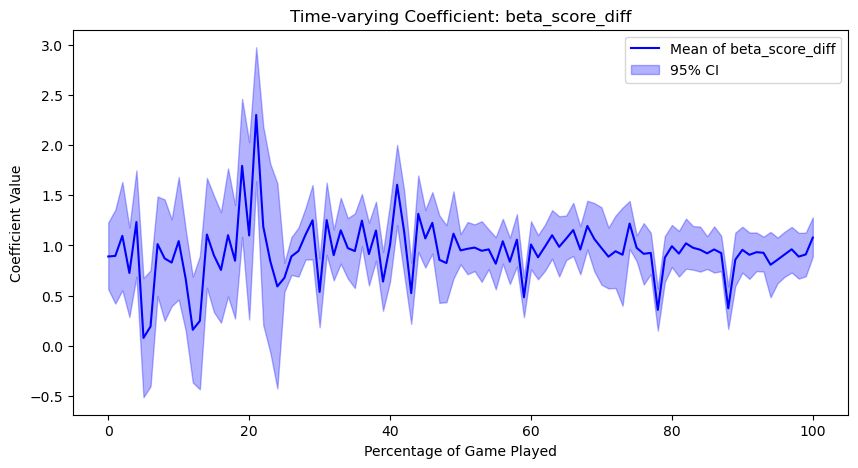

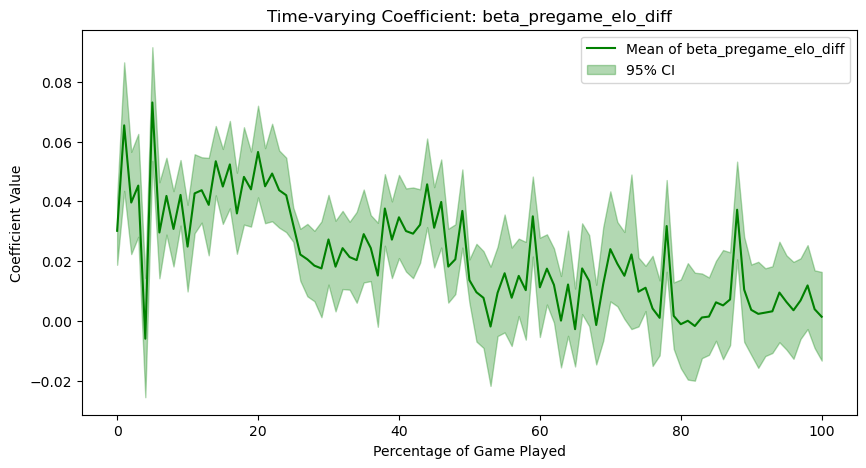

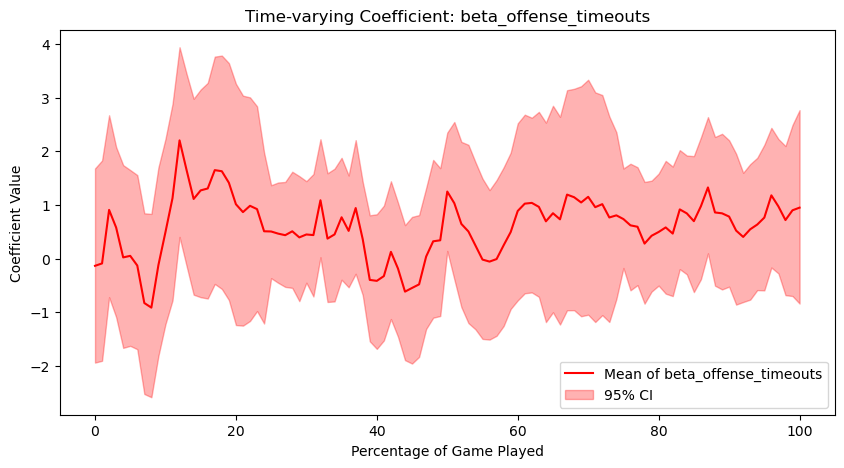

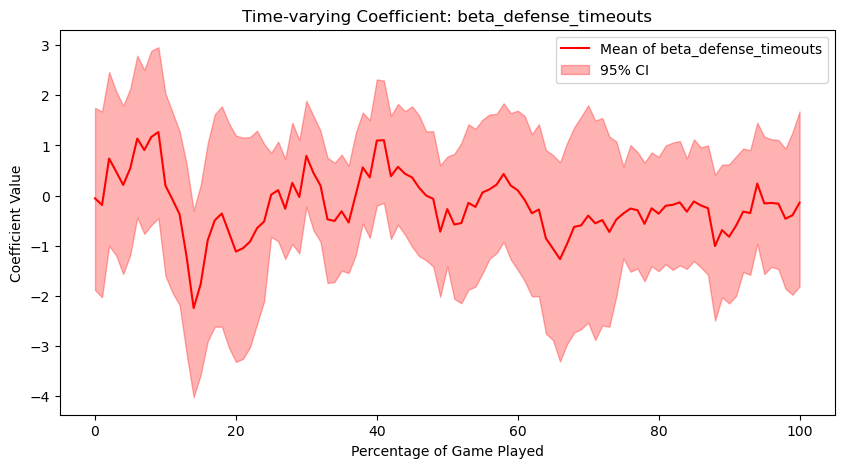

: 

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Extract the posterior means and credible intervals
beta_score_diff_trace = trace.posterior['beta_score_diff']
beta_pregame_elo_diff_trace = trace.posterior['beta_pregame_elo_diff']
beta_offense_timeouts_trace = trace.posterior['beta_offense_timeouts']
beta_defense_timeouts_trace = trace.posterior['beta_defense_timeouts']

# Compute the mean and 95% credible interval for each time bucket
beta_score_diff_mean = beta_score_diff_trace.mean(dim=['chain', 'draw'])
beta_score_diff_hpd = az.hdi(beta_score_diff_trace, hdi_prob=0.95).to_array().values

beta_pregame_elo_diff_mean = beta_pregame_elo_diff_trace.mean(dim=['chain', 'draw'])
beta_pregame_elo_diff_hpd = az.hdi(beta_pregame_elo_diff_trace, hdi_prob=0.95).to_array().values

beta_offense_timeouts_mean = beta_offense_timeouts_trace.mean(dim=['chain', 'draw'])
beta_offense_timeouts_hpd = az.hdi(beta_offense_timeouts_trace, hdi_prob=0.95).to_array().values

beta_defense_timeouts_mean = beta_defense_timeouts_trace.mean(dim=['chain', 'draw'])
beta_defense_timeouts_hpd = az.hdi(beta_defense_timeouts_trace, hdi_prob=0.95).to_array().values

# Create a time array corresponding to pct_game_played (0% to 100%)
time = np.arange(101)

# Plot the beta_score_diff coefficient over time
plt.figure(figsize=(10, 5))
plt.plot(time, beta_score_diff_mean, label='Mean of beta_score_diff', color='b')
plt.fill_between(time, beta_score_diff_hpd[0][:,0], beta_score_diff_hpd[0][:,1], color='b', alpha=0.3, label='95% CI')
plt.title('Time-varying Coefficient: beta_score_diff')
plt.xlabel('Percentage of Game Played')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

# Plot the beta_pregame_elo_diff coefficient over time
plt.figure(figsize=(10, 5))
plt.plot(time, beta_pregame_elo_diff_mean, label='Mean of beta_pregame_elo_diff', color='g')
plt.fill_between(time, beta_pregame_elo_diff_hpd[0][:,0], beta_pregame_elo_diff_hpd[0][:,1], color='g', alpha=0.3, label='95% CI')
plt.title('Time-varying Coefficient: beta_pregame_elo_diff')
plt.xlabel('Percentage of Game Played')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

# Plot the beta_offense_timeouts coefficient over time
plt.figure(figsize=(10, 5))
plt.plot(time, beta_offense_timeouts_mean, label='Mean of beta_offense_timeouts', color='r')
plt.fill_between(time, beta_offense_timeouts_hpd[0][:,0], beta_offense_timeouts_hpd[0][:,1], color='r', alpha=0.3, label='95% CI')
plt.title('Time-varying Coefficient: beta_offense_timeouts')
plt.xlabel('Percentage of Game Played')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

# Plot the beta_defense_timeouts coefficient over time
plt.figure(figsize=(10, 5))
plt.plot(time, beta_defense_timeouts_mean, label='Mean of beta_defense_timeouts', color='r')
plt.fill_between(time, beta_defense_timeouts_hpd[0][:,0], beta_defense_timeouts_hpd[0][:,1], color='r', alpha=0.3, label='95% CI')
plt.title('Time-varying Coefficient: beta_defense_timeouts')
plt.xlabel('Percentage of Game Played')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

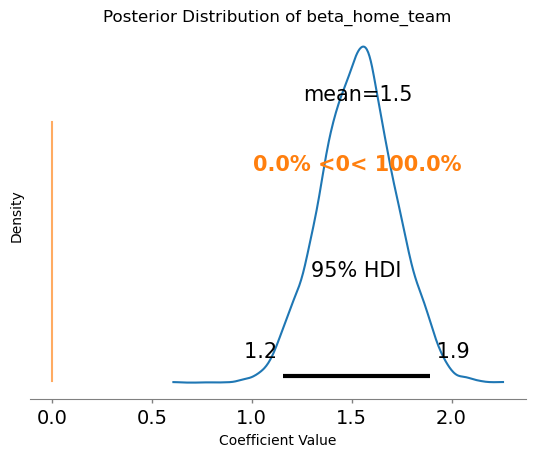

: 

In [ ]:
# plot the average distribution of beta_home_team
az.plot_posterior(trace, var_names=['beta_home_team'], ref_val=0, hdi_prob=0.95)
plt.title('Posterior Distribution of beta_home_team')
plt.xlabel('Coefficient Value')
plt.ylabel('Density')
plt.show()

# TODO:
- INCLUDE YARDS TO GO FEATURE (so the punt return model output has variable WP gained)